In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import fsolve

cm   = 1.
eV   = 1.
keV  = 1.e3*eV
MeV  = 10**6*eV
GeV  = 10**9*eV
kg   = (1.79e-30)**-1*MeV
s    = 1.
yr   = 365*24*60*60*s
c    = 1.
km   = cm*10**5

#bulk mass of Xe
m_Xe = 500*kg
#Avogadro constant
N_A  = 6.02214086e23
#mass number of Xe
A_Xe = 131.293
# minimum recoil energy for detection
E_R_low = 3*keV
#proton mass
m_p = 938.272*MeV
#observational duration
t_obs = 1*yr
#dark matter most probable velocity
v_0 = 220*km/s
#dark matter particle average velocity
v_av = 2*v_0/np.sqrt(np.pi)
#dark matter density
rho_DM = 0.3*GeV/cm**3

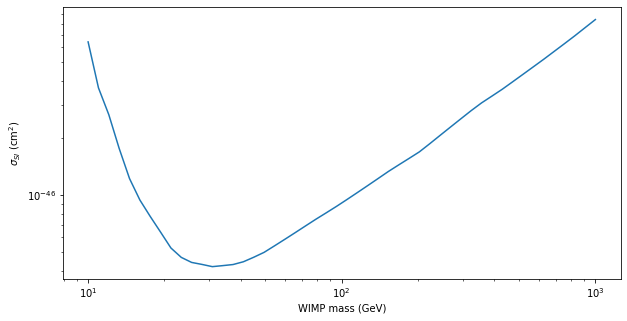

In [2]:
sigma_SI_data = np.genfromtxt('sigmaSI.csv', delimiter=',')
                             
sigma_SI=interp1d(sigma_SI_data[:,0]*GeV,sigma_SI_data[:,1],kind='linear',fill_value='extrapolate')
WIMP_mass_vect = np.logspace(1, 3)*GeV           
plt.figure(figsize=(10,5))
plt.plot(WIMP_mass_vect*GeV**-1, sigma_SI(WIMP_mass_vect))
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\sigma_{SI}$ (cm$^2$)')
plt.xlabel(r'WIMP mass (GeV)')
plt.show()

$500$ kg of Xenon

$1$ yr of observation time

$E_R>3$ keV

We need to find $\sigma_{SI}$ such that the expected number of events is $3$ which corresponds to a 95% confidence level upper limit



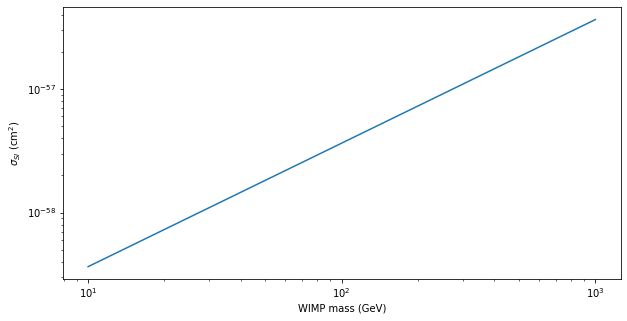

In [3]:
#calculate the expected 95% C.L. upper limits on the WIMP-proton coupling
#cross-sections as function of the dark matter mass

#calculate reduced mass
def mu(m_DM):
    return m_DM*A_Xe*m_p/(m_DM + A_Xe*m_p)


#calculate WIMP-proton coupling cross-section
def sigma(m_DM, sigma_SI):
    return sigma_SI*mu(m_DM)**2*A_Xe**2/m_p**2


#calculate 0-order interation rate:
def R_0(m_DM, sigma_SI):
    return (N_A)/(A_Xe)*(rho_DM/m_DM)*sigma(m_DM, sigma_SI)*v_av


def dRdE_R(m_DM, sigma_SI, E_R):
    E_0 = (1/2)*m_DM*v_av**2
    r = 4*mu(m_DM)**2/(m_DM*A_Xe*m_p)
    exponent = -E_R/(r*E_0)
    return (R_0(m_DM,sigma_SI)/(r*E_0))*np.exp(exponent)
    

def N_events(m_DM, sigma_SI):
    integrand = lambda E_R: dRdE_R(m_DM, sigma_SI, E_R)
    R = quad(integrand, E_R_low, np.inf)[0]
    return R*m_Xe*t_obs


def sigma_SI_solver(m_DM):
    equation = lambda sigma_SI: N_events(m_DM, sigma_SI)-3.
    guess = 10**-46
    return fsolve(equation, guess)

WIMP_mass_vect = np.logspace(1, 3)*GeV
sigma_SI_vect = []
for mass in WIMP_mass_vect:
    sigma_SI_vect.append(sigma_SI_solver(mass))
plt.figure(figsize=(10,5))
plt.plot(WIMP_mass_vect*GeV**-1, sigma_SI_vect)
plt.yscale('log')
plt.xscale('log')
plt.ylabel(r'$\sigma_{SI}$ (cm$^2$)')
plt.xlabel(r'WIMP mass (GeV)')
plt.show()